In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import AdamWeightDecay
from datasets import Dataset
import math
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt
import evaluate
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
import torch

2023-11-24 10:21:38.092320: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 10:21:38.092346: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 10:21:38.092374: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 10:21:38.097740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 10:21:38.615759: W tensorflow/compiler/

In [2]:
tf.config.experimental.list_physical_devices(device_type='GPU')

2023-11-24 10:21:40.555696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-24 10:21:40.559447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-24 10:21:40.559600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def json_to_dataframe(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.iloc[0])
    f.close()
    df["headline"]= df.apply(lambda x: x['masked headline'].replace('____', str(x['ans'])), axis=1)
    print(df.iloc[0])
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
    df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
    df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
    df = df.astype(str)
    return df

In [4]:
train_data = json_to_dataframe('Train_Numerical_Reasoning.json')

news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object
news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
headline            30K Walmart Part-Timers to Lose Health Insurance
Name: 0, dtype: object


In [5]:
train_data.head()

,news,masked headline,calculation,ans,headline,text
0,"As of Jan. 1, Walmart will no longer offer 30...",<extra_id_0> K Walmart Part-Timers to Lose Hea...,"Paraphrase(30,000,K)",30,30K Walmart Part-Timers to Lose Health Insurance,"As of Jan. 1, Walmart will no longer offer 30..."
1,Dax Shepard and Kristen Bell got married at t...,Dax Shepard: Wedding to Kristen Bell Cost $<ex...,Copy(142),142,Dax Shepard: Wedding to Kristen Bell Cost $142,Dax Shepard and Kristen Bell got married at t...
2,"Nancy Reagan, the helpmate, backstage adviser...",Nancy Reagan Dead at <extra_id_0> </s>,Copy(94),94,Nancy Reagan Dead at 94,"Nancy Reagan, the helpmate, backstage adviser..."
3,American Airlines faces FAA fines of more tha...,American Airlines Faces $<extra_id_0> M Fine f...,Copy(7),7,American Airlines Faces $7M Fine for Safety Vi...,American Airlines faces FAA fines of more tha...
4,"Ingrid Lyne, the Seattle mom allegedly murder...",$<extra_id_0> K Raised for Kids of Mom Dismemb...,"Paraphrase(222,000,K)",222,$222K Raised for Kids of Mom Dismembered on Date,"Ingrid Lyne, the Seattle mom allegedly murder..."


In [6]:
dataset = Dataset.from_pandas(train_data)
dataset = dataset.train_test_split(test_size=0.2)

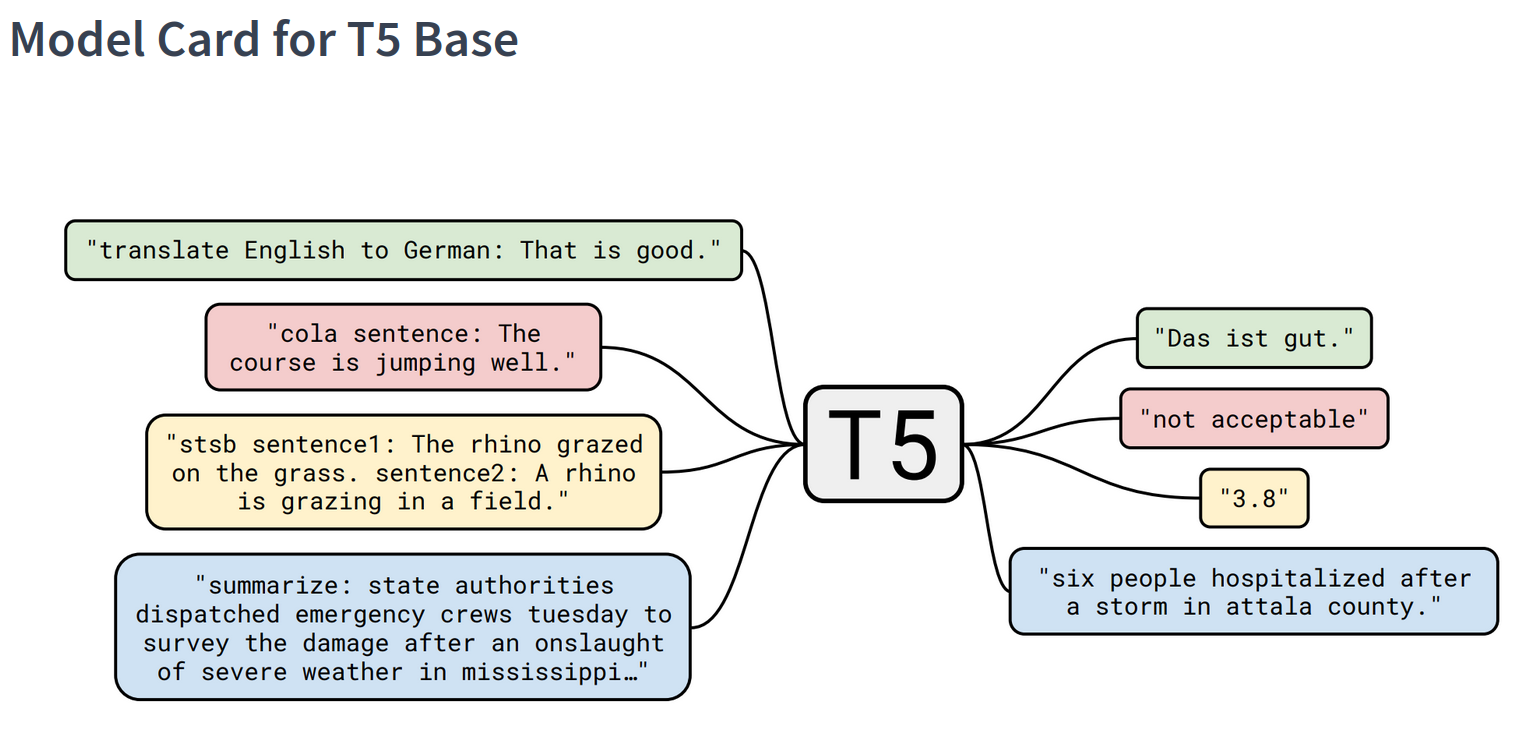

T5 is Text-to-Text-Transfer-Transformer model. It takes input texts for various NLP tasks and outputs the text for that respective task. 

T5 is slightly different from Masked Language Model such as BERT. Masked Language Models are Bidirectional models which use Mask token for each word while T5 replaces multiple consecutive tokens with a single Mask keyword. Since the final objective is to have trained a model that inputs text and outputs text, the targets were designed to produce a sequence, unlike BERT, that tries to output one word (itself). So t5 is suitable for text summarization and headline generation.

In [7]:
model_name ="czearing/article-title-generator"

### The model is based on t5-base and has been trained on a collection of 500k articles with headings. Its purpose is to create a one-line heading suitable for the given article. https://huggingface.co/Michau/t5-base-en-generate-headline

To prefix the input with a prompt so T5 knows this is a headline generation task

In [8]:
def preprocess_function(examples):   
    #inputs = [prefix + doc for doc in examples["news"]]
    inputs = tokenizer(examples['text'],max_length=3066,  truncation=True)
    labels = tokenizer(text_target=examples["headline"], max_length=1000, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

To apply the preprocess function over the entire dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
tokenized = dataset.map(preprocess_function, batched=True, #num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/16925 [00:00<?, ? examples/s]

Map:   0%|          | 0/4232 [00:00<?, ? examples/s]

To create batches using DataCollatorForSeq2Seq, which dynamically pads the sentences to the longest length in a batch during collation. This is  more efficient than padding the whole dataset to the maximum length. 

In [11]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                           model=model_name,
                                           return_tensors="tf")
#optimizer = AdamWeightDecay(learning_rate=1e-4, weight_decay_rate=0.01)
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)


To load pretrained T5-base michau with AutoModelForSeq2SeqLM

In [12]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name, from_pt=True)

2023-11-24 10:22:16.357332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-24 10:22:16.357591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-24 10:22:16.357822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

To convert datasets to the tf.data.Dataset format 

In [13]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=3,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=3,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [14]:
model.compile(optimizer=optimizer)

In [15]:
eval_loss = model.evaluate(tf_test_set)
print(f"Pretrained LM Perplexity: {math.exp(eval_loss):.2f}")

1411/1411 [==============================] - 101s 68ms/step - loss: 0.7598
Pretrained LM Perplexity: 2.14


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
history = model.fit(x=tf_train_set, validation_data=tf_test_set, callbacks=[callback], epochs=10)
#model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=1)
#eval_loss = model.evaluate(tf_test_set)
#print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

Epoch 1/10
5641/5641 [==============================] - 1335s 234ms/step - loss: 0.0762 - val_loss: 0.0489
Epoch 2/10
5641/5641 [==============================] - 1328s 235ms/step - loss: 0.0435 - val_loss: 0.0442
Epoch 3/10
5641/5641 [==============================] - 1312s 233ms/step - loss: 0.0310 - val_loss: 0.0485


In [17]:
eval_loss = model.evaluate(tf_test_set)
print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

1411/1411 [==============================] - 96s 68ms/step - loss: 0.0485
Finetuned Perplexity: 1.05


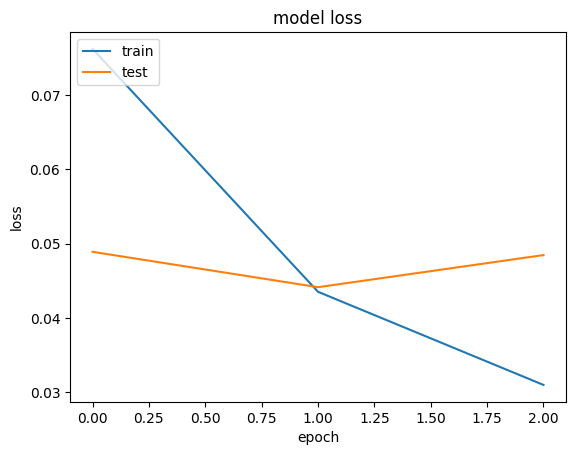

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
f = open('Dev_Numerical_Reasoning.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
df = df.astype(str)
#df = df.iloc[:200]
#df = df.iloc[100:500]
f.close()
test_data = Dataset.from_pandas(df)

In [20]:
# Try improved version
def t5_predictions(data, tokenizer, model):
    text = data['text']
    headline = data['masked headline']
    #print(headline)
    inputs = tokenizer.encode_plus(text, add_special_tokens=True,
                                   return_tensors="pt").input_ids
    outputs = model.generate(inputs,
                             max_length=128, num_beams=5, early_stopping=True)

    _0_index = headline.index('<extra_id_0> ')

    res = ''
    results = tokenizer.decode(outputs[0][1:], skip_special_tokens=False,
                               clean_up_tokenization_spaces=False)

    res = re.findall(r"(\d+[./]?\d*)", results[_0_index:_0_index+50])
    if len(res) < 1:
        res = re.findall(r"(\d+[./]?\d*)", results)
    try:
        return res[0]
    except:
        return ''

To load the ROUGE metric which stands for Recall-Oriented Understudy for Gisting Evaluation to calculates the similarity between the predicted headlines and actual headlines. ROUGE-N measures the number of matching n-grams between the model-generated text and an actual headline.



In [25]:
tru = 0
pred = []
for i in test_data:
    prediction1 = t5_predictions(i, tokenizer, model)
    pred.append(prediction1)
    print(prediction1)
    print(i['ans'])
    print("")
    if i['ans'] == prediction1:
        tru += 1


3
3

12
12

305
305

1
1

10
10

1959
1959

218
218

125
9

2
2

60
60

25
25

6
6

1.29
1

4
4

3
3

30
30

20
20

5
5

55
55

65
65

20
20

3
2

6
6

50
50

1999
2000

3
3

74
74

60
60

5
5

2
2

7
7

90
90

77
77

4
4

500
500

30
30

2
2

2012
2012

70
70

15
15

26
26

60
60

9
9

162
162

25
25

37
37

6
86

31
31

11
11

7
7

100
100

2
2

2
2

4
4

3
3

11
11

2
2

900
900

1791
1791

2
2

40
40

2
2

5
5

2.9
2.9

370
370

300
285

232
232

3
5

19
19

1
1

100
100

2
2

9/11
9/11

60
60

30
30

100
59

3
3

9
9

800
800

2.8
2.8

6
6

3
3

1
1

50
50

90
90

4
4.5

81
81

2
2

44
44

700
350

500
1

14
14

5
5

2.0
2.0

2
2

25
25

74
74

370
370

33
31

8
8

400
400

61
61

47
47

911
911

3
3

500
500

100
100

17
17

79
160

25
25

47
47

44
44

21
21

16
16

5
50

100
100

2
2

1
69

21
21

3.3
3.3

21
21

3
3

2
2

2
2

92
92

2
2

18
18

9
9

1
1

33
29

2
2

3
4

24
85

3
3

121
1892

3
17

3
3

94
94

4
4

12
13

2
2

6
6

6
6

25
25

22
22

3
2

500
500

30
30

30
1

100
100

2
2

3
3

12
12

75
75

7
7

44
44

8.3
8

11
11

2012
2012

73
73

21
21

3
3

2
2

612
612

38
38

1
2

5
5

1955
1955

25
25

2
2

6
6

120
120

161
161

5
5

10
1.5

43
43

2
2

39
39

11
11

2
2

3
3

4
4

50
50

82
82

7
7

1
2

40
40

1961
1961

7
7

5
5

873
873

3
3

1.2
1.2

2
2

27
27

15
15

50
6

25
35

84
84

1.6
1.6

3
3

10
20

16
16

27
27

10
10,000

80
80

9.4
9.4

30
30

100
100

2
2.5

75
75

23
23

30
30

67
67

70
70

40
40

85
85

2
2

10
10

1
1

3
3

2006
2006

215
215

5
11

5
5

5.99
6

2
2

3
3

20/20
20/20

10
5

92
92

4
4

1
1

10
10

700
700

9
9

250
250

13
13

2
2

3
3

80
1.9

83
84

15
15

21
21

3
3

111
100

175
175

3
3

8
8

780
780

4
4

37
37

123
123

23
23

8
8

18
18

28
28

3
3

2012
2012

1
1

60
30

121
121

2010
2010

50
50

86
86

10
10

99
99

10
10

2
2

2035
2035

45
45

73
73

3
3

2005
2005

7
7

6
6

3.6
3.6

10
10

09
09

3
3

10
10

53
53

108
108

7
7

3
3

2012
2012

16
16

25
25

118
118

30
30

22
22

50
50

18
18

911
911

20
20

100
100

75
75

5
5

6
6

10
10

2
2

30
30

2
2

60
60

2
2

1980
2

8
8

370
370

96
96

10
10

47
47

2
2

3
3

8.76
9

2
2

66
66

15
15

87
87

2
2

89
89

5
5

35
35

2020
2020

1
1

8
4

530
530

90
90

5
5

23
23

69
69

1977
1976

1
1

19
19

67
33

2000
2000

1
1.4

1920
1920

79
79

78
78

5
5

5
5

8
8

1995
1995

2
2

11
11

100
100

1
1

1
1

5
5

14
14

17
17

5
5

1
1

2
2

130
130

2.5
2.5

600
592

21
21.6

69
69

2018
2018

7
7

74
74

500
500

4
5

4
4

2
2

860
860

5
5

45
45

21
21

22
22

16
16

20
300

10
10

330
330

8
8

2016
2016

21.6
21.6

8
8

730
730

100
100

1
1

32
32

50
50

50
50

1.2
1.2

100
100

1
1

3
2

8
8

65
65

3
3

172
172

500
500

2013
2013

5
5

5
5

69
69

4
4

11
3

2011
2011

8
8

12
12

50.1
50.1

401
401

372
372

18
18

1
1

70
70

190
190

20
20

2
2

3
21

30
30

30
30

3
3

2016
2016

3
3

1
1

33.8
33

46
46

41
41

1
1

8
8

5
5

2030
2030

50
50

1
1

20
20

45
45

5
5

35
35

60
6

51
51

42.9
43

5
5

11
11

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(df['ans'], pred)

0.8783048211508554

In [27]:
tru

2259

In [28]:
tru/len(test_data)

0.8783048211508554